# MOSAIC Verification - Layer 2: Calculated Values

Numbers computed via explicit formulas from Layer 1 inputs.

**Dependencies:** config.py, functions.py

In [1]:
# Standard imports
from pathlib import Path
from typing import Optional
import math

# MOSAIC verification imports
from config import DATA, BTL2025_DECILES
from functions import (
    # CALC infrastructure
    load_calc, store, get, CALC,
    # Calculation functions
    calc_breakeven,
    calc_income_distribution_at_threshold,
    calc_optimal_taper_saez,
    calc_household_floor,
    calc_deflation_from_alpha,
    calc_vat_adjustment,
    calc_vat_revenue,
    calc_profit_trend_linear,
    calc_profit_trend_gdp_linked,
    calc_ringfenced_profit,
    calc_gov_ringfence,
    calc_consolidation_revenue,
    calc_gap_closure_pct,
    # Revenue-constrained floor mechanism
    calc_nit_cost_from_deciles,
    calc_floor_balanced,
    # CES production function
    ces_output,
    ces_labor_share,
    calibrate_ces_period_0,
    calc_growth_ces,
)

# Initialize CALC from disk (loads Layer 1 values from verify_layer1)
load_calc()
print(f"CALC initialized: Layer 1 has {len(CALC.get('layer1', {}))} values")

CALC initialized: Layer 1 has 0 values


---
# LAYER 2: Calculated Values

Numbers computed via explicit formulas from Layer 1 inputs.

## 2.1 Immediate Derivations

| ID | Description | Formula | Result |
|----|-------------|---------|--------|
| -- | Capital share | sK = 1 - sL | 0.44 |
| L0 | Initial employment | L0 = L_force * (1 - u0) | 4.365M |

In [2]:
print("=" * 60)
print("2.1 IMMEDIATE DERIVATIONS")
print("=" * 60)

# Get Layer 1 values using get() (searches CALC then DATA)
labor_share = get("labor_share")
L_force = get("labor_force")
u_0 = get("natural_unemployment") / 100

# Calculate and store
s_K = 1 - labor_share
store("capital_share", s_K, "layer2")
print(f"  capital_share: sK = 1 - {labor_share} = {s_K}")

L_0 = L_force * (1 - u_0)
store("L_0", L_0, "layer2")
print(f"  L_0: L0 = {L_force} * (1 - {u_0}) = {L_0:.3f}M")

2.1 IMMEDIATE DERIVATIONS
  capital_share: sK = 1 - 0.56 = 0.43999999999999995
  L_0: L0 = 4.5043 * (1 - 0.03) = 4.369M


## 2.1b CES Production Function: Y₁, g_Y

**Purpose:** Calculate GDP growth (g_Y) for fiscal capacity determination.

**Production Function:**
$$Y_t = A \cdot [\beta K^\rho + (1-\beta) L^\rho]^{1/\rho}$$

**Parameters:**
- $\sigma = 1.5$ (elasticity of substitution)
- $\rho = 1 - 1/\sigma = 1/3$
- $K_0 = 5,380B$ NIS (PWT 2023)

**Calibration:**
1. Given $Y_0$, $L_0$, $s_L$, $\sigma$, $K_0$, solve for $A_0$ and $\beta$
2. Apply TFP shock: $A_1 = \alpha \cdot A_0$
3. Calculate $Y_1 = \text{CES}(A_1, \beta, K_0, L_1)$
4. Growth rate: $g_Y = (Y_1 - Y_0) / Y_0$

**Dependency:** Floor calculations require fiscal capacity = (R - R₀) / C, which requires g_Y.

In [3]:
print("=" * 60)
print("2.1b CES PRODUCTION FUNCTION: Y1, gY, ΔS")
print("=" * 60)

# Get Layer 1 parameters using get()
Y_0 = get("Y0")
s_L = get("labor_share")
L_force = get("labor_force")
u_0 = get("natural_unemployment") / 100
sigma = get("sigma")
K_0 = get("K_0")

L_0 = L_force * (1 - u_0)

print(f"\nCES Calibration Parameters (from Layer 1):")
print(f"  Y0 = {Y_0:,.0f}B NIS")
print(f"  sL = {s_L}")
print(f"  L0 = {L_0:.3f}M workers")
print(f"  K0 = {K_0:,.1f}B NIS (PWT 2023)")
print(f"  sigma = {sigma} (rho = {1 - 1/sigma:.3f})")

# Calibrate CES
calib = calibrate_ces_period_0(Y_0, L_0, s_L, sigma, K_0)
print(f"\nCalibrated values:")
print(f"  A0 = {calib['A']:.4f}")
print(f"  beta = {calib['beta']:.4f}")

# Store calibration results
store("A_0", calib['A'], "layer2")
store("beta_ces", calib['beta'], "layer2")

# Verify calibration
Y_check = ces_output(calib['A'], calib['beta'], K_0, L_0, sigma)
sL_check = ces_labor_share(calib['beta'], K_0, L_0, sigma)
print(f"\nCalibration verification:")
print(f"  Y(A0,K0,L0) = {Y_check:.1f}B (target: {Y_0})")
print(f"  sL(K0,L0) = {sL_check:.3f} (target: {s_L})")

# Scenario calculations for g_Y and ΔS
scenarios = [
    ("Low Displacement", "low_displacement", get("alpha_low_displacement"), get("s_L_prime_low_displacement"),
     get("u_low_displacement")/100, "g_Y_low_displacement"),
    ("Strong", "strong", get("alpha_strong"), get("s_L_prime_strong"),
     get("u_strong")/100, "g_Y_strong"),
    ("AGI", "agi", get("alpha_agi"), get("s_L_prime_agi"),
     get("u_agi")/100, "g_Y_agi"),
    ("ASI", "asi", get("alpha_asi"), get("s_L_prime_asi"),
     get("u_asi")/100, "g_Y_asi"),
]

print(f"\n{'Scenario':<10} {'alpha':>6} {'sL_p':>5} {'u':>5} {'Y1':>8} {'g_Y':>6} {'ΔS':>8}")
print("-" * 55)

# Initial labor income for ΔS calculation
labor_income_0 = s_L * Y_0
capital_income_0 = (1 - s_L) * Y_0

for name, key, alpha, s_L_prime, u, g_Y_key in scenarios:
    result = calc_growth_ces(
        alpha=alpha, s_L_prime=s_L_prime, u=u,
        Y_0=Y_0, s_L=s_L, L_force=L_force, u_0=u_0,
        sigma=sigma, K_0=K_0
    )
    
    g_Y_calc = result['g_Y_pct']
    Y_1 = result['Y_1']
    
    # Automation Surplus: ΔS = s_L' × Y₁ - s_L × Y₀
    labor_income_1 = s_L_prime * Y_1
    delta_S = labor_income_1 - labor_income_0
    
    # Capital Windfall: ΔΠ = s_K' × Y₁ - s_K × Y₀
    capital_income_1 = (1 - s_L_prime) * Y_1
    delta_Pi = capital_income_1 - capital_income_0
    
    # Store calculated values to Layer 2
    store(g_Y_key, g_Y_calc, "layer2")
    store(f"Y_1_{key}", Y_1, "layer2")
    store(f"delta_S_{key}", delta_S, "layer2")
    store(f"delta_Pi_{key}", delta_Pi, "layer2")
    
    marker = "**" if name in ("AGI", "ASI") else "  "
    print(f"{marker}{name:<8} {alpha:>6.1f} {s_L_prime:>5.2f} {u*100:>4.0f}% {Y_1:>7.0f}B {g_Y_calc:>5.0f}% {delta_S:>7.0f}B")

print("-" * 55)
print(f"\nLabor Income: ΔS = s_L' × Y₁ - s_L × Y₀")
print(f"  Initial labor income: s_L × Y₀ = {s_L} × {Y_0} = {labor_income_0:.0f}B")
print(f"  Positive ΔS when: Y₁/Y₀ > s_L/s_L' (growth exceeds displacement)")

# Gap closure calculation for ΔS < 0 scenarios
print(f"\n--- Gap Closure Calculation ---")
print(f"When ΔS < 0, what % of ΔΠ is needed to close the labor income gap?")
print(f"Formula: gap_closure_pct = |ΔS| / ΔΠ × 100")
print(f"\n{'Scenario':<10} {'ΔS':>8} {'ΔΠ':>8} {'Gap %':>8}")
print("-" * 38)
for name, key, alpha, s_L_prime, u, g_Y_key in scenarios:
    delta_S = get(f"delta_S_{key}")
    delta_Pi = get(f"delta_Pi_{key}")
    gap_pct = calc_gap_closure_pct(delta_S, delta_Pi)
    store(f"gap_closure_{key}", gap_pct, "layer2")
    marker = "**" if name in ("AGI", "ASI") else "  "
    gap_str = f"{gap_pct:.1f}%" if gap_pct > 0 else "N/A"
    print(f"{marker}{name:<8} {delta_S:>7.0f}B {delta_Pi:>7.0f}B {gap_str:>8}")
print("-" * 38)
print(f"Note: ASI gap closure = 9% - 91% of ΔΠ remains for poverty-eliminating transfers")

print(f"\nNote: K constant (K1 = K0). Y1, g_Y, ΔS, ΔΠ stored to CALC.")
print(f"      AGI = decision scenario; ASI = stress test")

2.1b CES PRODUCTION FUNCTION: Y1, gY, ΔS

CES Calibration Parameters (from Layer 1):
  Y0 = 1,694B NIS
  sL = 0.56
  L0 = 4.369M workers
  K0 = 4,708.1B NIS (PWT 2023)
  sigma = 1.5 (rho = 0.333)



Calibrated values:
  A0 = 84.9745
  beta = 0.0712

Calibration verification:
  Y(A0,K0,L0) = 1694.0B (target: 1694)
  sL(K0,L0) = 0.560 (target: 0.56)

Scenario    alpha  sL_p     u       Y1    g_Y       ΔS
-------------------------------------------------------
  Low Displacement    1.4  0.50    6%    2330B    38%     217B
  Strong      1.6  0.42   10%    2600B    53%     143B
**AGI         2.2  0.35   40%    2875B    70%      58B
**ASI         3.0  0.25   60%    3197B    89%    -149B
-------------------------------------------------------

Labor Income: ΔS = s_L' × Y₁ - s_L × Y₀
  Initial labor income: s_L × Y₀ = 0.56 × 1694 = 949B
  Positive ΔS when: Y₁/Y₀ > s_L/s_L' (growth exceeds displacement)

--- Gap Closure Calculation ---
When ΔS < 0, what % of ΔΠ is needed to close the labor income gap?
Formula: gap_closure_pct = |ΔS| / ΔΠ × 100

Scenario         ΔS       ΔΠ    Gap %
--------------------------------------
  Low Displacement     217B     420B      N/A
  Strong       143B    

## Figure 1: Labor Income vs Capital Winsfall

Shows how labor income changes across scenarios, and the growing capital windfall.

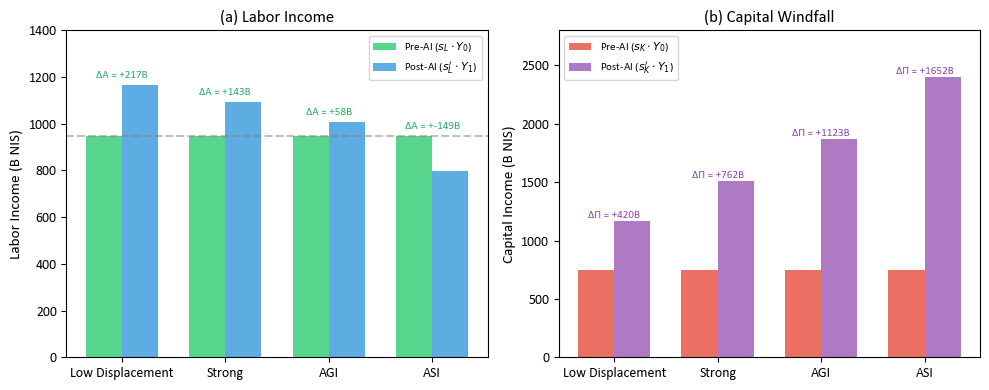

Saved: ..\Paper\Figures\fig1_surplus_decomposition.pdf


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Create Figures directory
FIGURES_DIR = Path('../Paper/Figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Style settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Calibri', 'Arial', 'Helvetica'],
    'font.size': 10,
    'axes.labelsize': 11,
    'figure.figsize': (10, 4),
    'figure.dpi': 100,
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

scenarios = ['Low Displacement', 'Strong', 'AGI', 'ASI']
s_L = get('labor_share')  # 0.56
Y0 = get('Y0')  # 1694

# Pre-automation labor income (same for all)
labor_pre = s_L * Y0  # 949B

# Post-automation labor income
labor_post = [
    get('s_L_prime_low_displacement') * get('Y_1_low_displacement'),
    get('s_L_prime_strong') * get('Y_1_strong'),
    get('s_L_prime_agi') * get('Y_1_agi'),
    get('s_L_prime_asi') * get('Y_1_asi'),
]

# Labor Income
surplus = [lp - labor_pre for lp in labor_post]

# Capital windfall
s_K = 1 - s_L
capital_pre = s_K * Y0
capital_post = [
    (1 - get('s_L_prime_low_displacement')) * get('Y_1_low_displacement'),
    (1 - get('s_L_prime_strong')) * get('Y_1_strong'),
    (1 - get('s_L_prime_agi')) * get('Y_1_agi'),
    (1 - get('s_L_prime_asi')) * get('Y_1_asi'),
]
windfall = [cp - capital_pre for cp in capital_post]

# Panel A: Labor Income
x = np.arange(len(scenarios))
width = 0.35

ax1.bar(x - width/2, [labor_pre]*4, width, label=r'Pre-AI ($s_L \cdot Y_0$)', color='#2ecc71', alpha=0.8)
ax1.bar(x + width/2, labor_post, width, label=r"Post-AI ($s_L' \cdot Y_1$)", color='#3498db', alpha=0.8)

for i, (pre, post, s) in enumerate(zip([labor_pre]*4, labor_post, surplus)):
    ax1.annotate(f'ΔA = +{s:.0f}B', xy=(i, max(pre, post) + 30),
                ha='center', fontsize=8, color='#27ae60')

ax1.set_ylabel('Labor Income (B NIS)')
ax1.set_title('(a) Labor Income')
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend(loc='upper right', fontsize=8)
ax1.set_ylim(0, 1400)
ax1.axhline(y=labor_pre, color='gray', linestyle='--', alpha=0.5)

# Panel B: Capital Windfall
ax2.bar(x - width/2, [capital_pre]*4, width, label=r'Pre-AI ($s_K \cdot Y_0$)', color='#e74c3c', alpha=0.8)
ax2.bar(x + width/2, capital_post, width, label=r"Post-AI ($s_K' \cdot Y_1$)", color='#9b59b6', alpha=0.8)

for i, (pre, post, w) in enumerate(zip([capital_pre]*4, capital_post, windfall)):
    ax2.annotate(f'ΔΠ = +{w:.0f}B', xy=(i, post + 30),
                ha='center', fontsize=8, color='#8e44ad')

ax2.set_ylabel('Capital Income (B NIS)')
ax2.set_title('(b) Capital Windfall')
ax2.set_xticks(x)
ax2.set_xticklabels(scenarios)
ax2.legend(loc='upper left', fontsize=8)
ax2.set_ylim(0, 2800)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_surplus_decomposition.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig1_surplus_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig1_surplus_decomposition.pdf'}")

## 2.2a Break-even Income (N06)

**Formula:** $y^* = D + \frac{M}{\tau}$

**Inputs:**
- D = 1,000 (disregard)
- M = 6,350 (floor)
- tau = 0.50 (taper)

**Output:** y* = 13,700 NIS/mo

**Function:** `calc_breakeven()`

In [5]:
print("=" * 60)
print("2.2a BREAK-EVEN INCOME (N06)")
print("=" * 60)

# Get Layer 1 design parameters
D = get("disregard")
M = get("floor_reference")
tau = get("taper_implemented")

y_star_calc = calc_breakeven(D=D, M=M, tau=tau)

print(f"  y* = D + M/tau = {D} + {M}/{tau}")
print(f"     = {y_star_calc:,.0f} NIS/mo")
store("breakeven_income", y_star_calc, "layer2")

2.2a BREAK-EVEN INCOME (N06)
  y* = D + M/tau = 1000 + 6350/0.5
     = 13,700 NIS/mo


13700.0

## 2.2b Income Distribution at Break-even (D03, D04)

**Source:** BTL2025 wage decile data (NII H1 2025)

**Method:**
1. F(y*): Linear interpolation within decile containing y*
2. Mean below y*: Weighted sum of full deciles + partial decile

**Inputs:**
- BTL2025_DECILES (defined in Function Library)
- y* = 13,700 NIS/mo (break-even income)

**Outputs:**
- F(y*) = 0.621 (62.1% of workers earn below y*)
- Mean income below y* = 6,791 NIS/mo

**Function:** `calc_income_distribution_at_threshold()`

In [6]:
print("=" * 60)
print("2.2b INCOME DISTRIBUTION AT BREAK-EVEN (BTL2025)")
print("=" * 60)

# Use calculated breakeven from CALC
y_star = get("breakeven_income")
print(f"\nBreak-even income: y* = {y_star:,} NIS/mo (from Layer 2)")

# Calculate using function
result = calc_income_distribution_at_threshold(BTL2025_DECILES, y_star)

print(f"\nStep 1: F(y*) - CDF at break-even")
print(f"  y* = {y_star:,} falls in decile {result['target_decile']}")
print(f"  F(y*) = {(result['target_decile']-1)/10:.2f} + 0.10 * {result['fraction_in_decile']:.4f} = {result['F_y']:.4f}")

print(f"\nStep 2: Mean income below y*")
print(f"  Workers below y*: {result['total_workers_below']:,.0f}")
print(f"  Mean = {result['mean_below']:,.0f} NIS/mo")

print(f"\nStoring to Layer 2:")
store("F_y_star", result['F_y'], "layer2")
print(f"  F_y_star: {result['F_y']:.4f}")
store("mean_below_breakeven", result['mean_below'], "layer2")
print(f"  mean_below_breakeven: {result['mean_below']:,.0f}")

2.2b INCOME DISTRIBUTION AT BREAK-EVEN (BTL2025)

Break-even income: y* = 13,700.0 NIS/mo (from Layer 2)

Step 1: F(y*) - CDF at break-even
  y* = 13,700.0 falls in decile 7
  F(y*) = 0.60 + 0.10 * 0.2146 = 0.6215

Step 2: Mean income below y*
  Workers below y*: 2,277,831
  Mean = 6,791 NIS/mo

Storing to Layer 2:
  F_y_star: 0.6215
  mean_below_breakeven: 6,791


## 2.2c Household Floors (OECD scale)

**Formula:** $F_h = M \times \text{scale} + \psi$ (if single parent)

**OECD Scale:** 1.0 (first adult) + 0.5 (additional adult) + 0.3 (child)

| Household | Scale | Floor |
|-----------|-------|-------|
| Single | 1.0 | 6,350 |
| Couple | 1.5 | 9,525 |
| Couple + 2 kids | 2.1 | 13,335 |
| Single parent + 2 | 1.6 + psi | 11,060 |

**Function:** `calc_household_floor()`

In [7]:
print("=" * 60)
print("2.2c HOUSEHOLD FLOORS (OECD scale)")
print("=" * 60)

# Get design parameters from Layer 1
M = get("floor_reference")
psi = get("single_parent_topup")

floors = [
    ("H01: Single", "floor_single", 1, 0, False, 1.0),
    ("H02: Couple", "floor_couple", 2, 0, False, 1.5),
    ("H03: Couple+2", "floor_couple_2kids", 2, 2, False, 2.1),
    ("H04: SingleParent+2", "floor_single_parent_2kids", 1, 2, True, 1.6),
]

for name, key, adults, children, single_parent, expected_scale in floors:
    floor = calc_household_floor(M, adults, children, single_parent, psi)
    store(key, floor, "layer2")
    print(f"  {name}: M * {expected_scale} {'+psi' if single_parent else ''} = {floor:,.0f}")

2.2c HOUSEHOLD FLOORS (OECD scale)
  H01: Single: M * 1.0  = 6,350
  H02: Couple: M * 1.5  = 9,525
  H03: Couple+2: M * 2.1  = 13,335
  H04: SingleParent+2: M * 1.6 +psi = 11,060


## 2.3 Saez Formula Components (N05)

**Formula:** $\frac{\tau}{1-\tau} = \frac{1}{\varepsilon} \cdot \frac{\bar{y}}{y^*} \cdot \frac{1-F(y^*)}{F(y^*)}$

**Inputs:**
- epsilon = 0.39 (Taub 2024 weighted average)
- ybar = 6,791 NIS/mo
- y* = 13,700 NIS/mo
- F(y*) = 0.621

**Output:** tau* ~ 0.45

**Function:** `calc_optimal_taper_saez()`

In [8]:
print("=" * 60)
print("2.3 SAEZ FORMULA COMPONENTS (N05)")
print("=" * 60)

# Get Layer 2 calculated values
y_bar = get("mean_below_breakeven")
y_star = get("breakeven_income")
F_y_star = get("F_y_star")

# Calculate epsilon_weighted (Layer 2 calculation)
eps_intensive = get("epsilon_intensive")
eps_extensive = get("epsilon_extensive")
epsilon_calc = (eps_intensive + eps_extensive) / 2
store("epsilon_weighted", epsilon_calc, "layer2")
print(f"  epsilon_weighted: {epsilon_calc:.4f}")

print(f"\nComponents:")
print(f"  ybar/y* = {y_bar}/{y_star} = {y_bar/y_star:.3f}")
print(f"  (1-F)/F = (1-{F_y_star})/{F_y_star} = {(1-F_y_star)/F_y_star:.3f}")

print(f"\nWith calculated elasticity (eps = {epsilon_calc}):")
tau_star = calc_optimal_taper_saez(epsilon_calc, y_bar, y_star, F_y_star)
print(f"  tau* = {tau_star:.3f}")
store("taper_optimal", tau_star, "layer2")

2.3 SAEZ FORMULA COMPONENTS (N05)
  epsilon_weighted: 0.3925

Components:
  ybar/y* = 6791.094884560188/13700.0 = 0.496
  (1-F)/F = (1-0.6214577442664153)/0.6214577442664153 = 0.609

With calculated elasticity (eps = 0.3925):
  tau* = 0.435


0.43479714207310083

## 2.3a Taper Sensitivity Analysis (AS01-AS04)

**Purpose:** Verify Paper Appendix A sensitivity table.

**Formula:** $\tau^* = \frac{\text{RHS}}{1 + \text{RHS}}$ where $\text{RHS} = \frac{1}{\varepsilon} \cdot \frac{\bar{y}}{y^*} \cdot \frac{1-F}{F}$

**Inputs:** Fixed: ȳ=6791, y*=13700, F=0.621. Varying: ε ∈ {0.30, 0.35, 0.39, 0.45}

In [9]:
print("=" * 60)
print("2.3a TAPER SENSITIVITY (AS01-AS04)")
print("=" * 60)

# Get Layer 2 calculated values
y_bar = get("mean_below_breakeven")
y_star = get("breakeven_income")
F_y_star = get("F_y_star")

# Elasticity values to test
SENSITIVITY = [
    ("AS01", 0.30),
    ("AS02", 0.35),
    ("AS03", 0.39),  # Taub 2024 weighted average
    ("AS04", 0.45),
]

print(f"Verified inputs (BTL2025):")
print(f"  ybar = {y_bar:,.0f} NIS/mo")
print(f"  y* = {y_star:,.0f} NIS/mo")
print(f"  F(y*) = {F_y_star}")

# Calculate components
ybar_ystar = y_bar / y_star
cdf_ratio = (1 - F_y_star) / F_y_star
print(f"Saez components:")
print(f"  ybar/y* = {ybar_ystar:.3f}")
print(f"  (1-F)/F = {cdf_ratio:.3f}")

print(f"{'ID':<6} {'eps':>6} {'tau*':>8}")
print("-" * 22)

results = []
for id, eps in SENSITIVITY:
    # Saez formula: tau/(1-tau) = (1/eps) * (ybar/y*) * ((1-F)/F)
    rhs = (1/eps) * ybar_ystar * cdf_ratio
    tau_star = rhs / (1 + rhs)
    results.append((id, eps, tau_star))
    print(f"{id:<6} {eps:>6.2f} {tau_star:>8.2f}")

print("-" * 22)

# Verify AS03 matches calculated taper_optimal
tau_taub = results[2][2]  # AS03
tau_optimal = get("taper_optimal")
print(f"Verification:")
print(f"  Taub eps=0.39 -> tau*={tau_taub:.2f}")
print(f"  Stored taper_optimal = {tau_optimal:.2f}")

if abs(tau_taub - tau_optimal) < 0.01:
    print("  [OK] Match")

tau_impl = get("taper_implemented")
print(f"Implemented tau = {tau_impl:.2f}")
print(f"Margin: {(tau_impl - tau_taub)*100:.0f}pp above optimal")

2.3a TAPER SENSITIVITY (AS01-AS04)
Verified inputs (BTL2025):
  ybar = 6,791 NIS/mo
  y* = 13,700 NIS/mo
  F(y*) = 0.6214577442664153
Saez components:
  ybar/y* = 0.496
  (1-F)/F = 0.609
ID        eps     tau*
----------------------
AS01     0.30     0.50
AS02     0.35     0.46
AS03     0.39     0.44
AS04     0.45     0.40
----------------------
Verification:
  Taub eps=0.39 -> tau*=0.44
  Stored taper_optimal = 0.43
  [OK] Match
Implemented tau = 0.50
Margin: 6pp above optimal


## 2.4 VAT Adjustment (V03a-d)

**Formula:** $v_1 = \frac{1+v_0}{1-\delta} - 1$

**Deflation derived from TFP multiplier (α):**
- Anchor: Low Displacement (α=1.4) = BLS historical software deflation (5%/yr)
- Above baseline: Apply 40% AI-exposure factor (sensitivity to excess TFP)
- Formula: $\delta = \delta_{BLS} \times [1 + 0.40 \times (\alpha - \alpha_{BLS}) / (\alpha_{BLS} - 1)]$ for $\alpha > 1.4$

**Scenario-Specific Results:**
| Scenario | α | δ | v1 | Δv |
|----------|---|---|----|----|
| Low Displacement | 1.4 | 5% | 24.2% | 6.2pp |
| Strong | 1.6 | 6% | 25.5% | 7.5pp |
| AGI | 2.2 | 9% | 29.7% | 11.7pp |
| ASI | 3.0 | 13% | 35.6% | 17.6pp |

**Source:** BLS software price deflation (BLSSoftwareCPI)

**Function:** `calc_deflation_from_alpha()`, `calc_vat_adjustment()`

In [10]:
print("=" * 60)
print("2.4 VAT ADJUSTMENT (V03a-d)")
print("=" * 60)

# Get Layer 1 VAT baseline
v0 = get("vat_baseline") / 100

# Get BLS deflation parameters
bls_delta = get("bls_deflation_rate") / 100       # 5%
alpha_bls = get("bls_deflation_alpha")            # 1.4
ai_exposure = get("ai_consumption_exposure") / 100  # 40%

print(f"\nDeflation derived from TFP multiplier (α):")
print(f"  BLS anchor: δ = {bls_delta*100:.0f}% at α = {alpha_bls}")
print(f"  AI exposure factor: {ai_exposure*100:.0f}%")
print(f"  Formula: δ = δ_BLS × [1 + ai_exposure × (α - α_BLS) / (α_BLS - 1)] for α > {alpha_bls}")

# Calculate deflation from alpha for each scenario
scenarios = [
    ("low_displacement", get("alpha_low_displacement")),
    ("strong", get("alpha_strong")),
    ("agi", get("alpha_agi")),
    ("asi", get("alpha_asi")),
]

for name, alpha in scenarios:
    # Calculate deflation from alpha
    delta = calc_deflation_from_alpha(alpha, bls_delta, alpha_bls, ai_exposure)
    delta_pct = delta * 100
    
    # Store deflation to Layer 2
    store(f"deflation_{name}", delta_pct, "layer2")
    
    # Calculate VAT adjustment
    v1 = calc_vat_adjustment(v0, delta)
    v1_pct = v1 * 100
    delta_v = v1_pct - get("vat_baseline")
    
    marker = "**" if name in ("agi", "asi") else ""
    print(f"\n{marker}{name.title()} (α = {alpha}):")
    print(f"  δ = {delta_pct:.0f}%")
    print(f"  v1 = (1 + {v0})/(1 - {delta:.2f}) - 1 = {v1_pct:.1f}%")
    print(f"  Δv = {delta_v:.1f}pp")
    store(f"vat_adjusted_{name}", v1_pct, "layer2")

2.4 VAT ADJUSTMENT (V03a-d)

Deflation derived from TFP multiplier (α):
  BLS anchor: δ = 5% at α = 1.4
  AI exposure factor: 40%
  Formula: δ = δ_BLS × [1 + ai_exposure × (α - α_BLS) / (α_BLS - 1)] for α > 1.4

Low_Displacement (α = 1.4):
  δ = 5%
  v1 = (1 + 0.18)/(1 - 0.05) - 1 = 24.2%
  Δv = 6.2pp

Strong (α = 1.6):
  δ = 6%
  v1 = (1 + 0.18)/(1 - 0.06) - 1 = 25.5%
  Δv = 7.5pp

**Agi (α = 2.2):
  δ = 9%
  v1 = (1 + 0.18)/(1 - 0.09) - 1 = 29.7%
  Δv = 11.7pp

**Asi (α = 3.0):
  δ = 13%
  v1 = (1 + 0.18)/(1 - 0.13) - 1 = 35.6%
  Δv = 17.6pp


## 2.4a VAT Pass-through Estimation (V04)

**Method:** Event study using 16 VAT reforms (1982-2025).

**Data:** 
- VAT history: `israel_vat_history.csv`
- CPI General index: `price_indices.csv`

**Specification:**
For each VAT change event, compute pass-through as:
$$\beta = \frac{\Delta \ln P}{\Delta \tau / (1 + \tau_{\text{old}})}$$

Where:
- $\Delta \ln P$ = log price change from month before to month of VAT change
- $\Delta \tau$ = VAT rate change (in percentage points)
- $\tau_{\text{old}}$ = VAT rate before change

**Note:** Denominator adjusts for VAT-inclusive pricing (100% pass-through means prices rise by $\Delta\tau/(1+\tau)$).

In [11]:
print("=" * 60)
print("2.4a VAT PASS-THROUGH ESTIMATION (V04)")
print("=" * 60)

import pandas as pd
import numpy as np
from pathlib import Path

# Get path relative to notebook location
data_dir = Path('Data')

# Load VAT history (17 events from 1977-2025)
df_vat = pd.read_csv(data_dir / 'israel_vat_history.csv')
df_vat['Date'] = pd.to_datetime(df_vat['Date'], format='%d.%m.%Y')
df_vat = df_vat.sort_values('Date')
df_vat['VAT_change'] = df_vat['VAT_Rate_Percent'].diff()

# Load CPI (General index - already filtered in CSV)
df_cpi = pd.read_csv(data_dir / 'price_indices.csv')
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
records = []
for _, row in df_cpi.iterrows():
    year = row['Year']
    if pd.isna(year):
        continue
    for m_idx, month in enumerate(months):
        price = row[month]
        if pd.notna(price):
            records.append({'Year': int(year), 'Month': m_idx + 1, 'Price': float(price)})
df_long = pd.DataFrame(records)
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'].astype(str) + '-01')
df_general = df_long.set_index('Date')['Price']

# Event study: price change around VAT events
results = []
for _, vat_row in df_vat.iterrows():
    event_date = vat_row['Date']
    vat_change = vat_row['VAT_change']
    
    if pd.isna(vat_change) or vat_change == 0:
        continue
    
    old_rate = vat_row['VAT_Rate_Percent'] - vat_change
    pre_date = (event_date - pd.DateOffset(months=1)).replace(day=1)
    event_month = event_date.replace(day=1)
    
    if pre_date not in df_general.index or event_month not in df_general.index:
        continue
    
    price_change = (df_general[event_month] / df_general[pre_date] - 1) * 100
    expected_full = vat_change / (1 + old_rate/100)  # VAT-inclusive price effect
    passthrough = price_change / expected_full
    
    results.append({
        'Event': event_date.strftime('%Y-%m'),
        'VAT_change': vat_change,
        'Price_change': price_change,
        'Expected_full': expected_full,
        'Passthrough': passthrough,
        'Is_increase': vat_change > 0
    })

df_results = pd.DataFrame(results)

print(f"VAT events analyzed: {len(df_results)}")
print(f"All events: Mean PT = {df_results['Passthrough'].mean()*100:.0f}%, Median = {df_results['Passthrough'].median()*100:.0f}%")

# Post-1995 events (stable inflation period), excluding outliers (|PT| > 300%)
OUTLIER_THRESHOLD = 3  # 300%
df_post95_all = df_results[df_results['Event'] >= '1995']
df_outliers = df_post95_all[df_post95_all['Passthrough'].abs() >= OUTLIER_THRESHOLD]
df_post95 = df_post95_all[df_post95_all['Passthrough'].abs() < OUTLIER_THRESHOLD]

print(f"POST-1995 VAT CHANGES (n={len(df_post95)}, excluding {len(df_outliers)} outliers with |PT|>{OUTLIER_THRESHOLD*100:.0f}%):")
for _, r in df_post95.iterrows():
    direction = "+" if r['VAT_change'] > 0 else ""
    print(f"  {r['Event']}: VAT {direction}{r['VAT_change']:.1f}pp -> CPI {r['Price_change']:+.2f}% (PT: {r['Passthrough']*100:.0f}%)")

if len(df_outliers) > 0:
    print(f"Excluded outliers:")
    for _, r in df_outliers.iterrows():
        direction = "+" if r['VAT_change'] > 0 else ""
        print(f"  {r['Event']}: VAT {direction}{r['VAT_change']:.1f}pp -> CPI {r['Price_change']:+.2f}% (PT: {r['Passthrough']*100:.0f}%)")

mean_pt = df_post95['Passthrough'].mean()
median_pt = df_post95['Passthrough'].median()
print(f"Mean: {mean_pt*100:.0f}%, Median: {median_pt*100:.0f}%")

# Separate by direction
df_inc = df_post95[df_post95['Is_increase']]
df_dec = df_post95[~df_post95['Is_increase']]
if len(df_inc) > 0:
    print(f"  Increases only (n={len(df_inc)}): Mean = {df_inc['Passthrough'].mean()*100:.0f}%")
if len(df_dec) > 0:
    print(f"  Decreases only (n={len(df_dec)}): Mean = {df_dec['Passthrough'].mean()*100:.0f}%")

# Store empirical passthrough estimate
vat_pt_empirical = df_inc['Passthrough'].mean()
print(f"\nEmpirical estimate (increases): {vat_pt_empirical*100:.0f}%")

# Store vat_passthrough to Layer 2 (empirical estimate)
store("vat_passthrough", vat_pt_empirical, "layer2")

2.4a VAT PASS-THROUGH ESTIMATION (V04)


VAT events analyzed: 16
All events: Mean PT = 43%, Median = 44%
POST-1995 VAT CHANGES (n=9, excluding 1 outliers with |PT|>300%):
  2002-06: VAT +1.0pp -> CPI +1.31% (PT: 154%)
  2004-03: VAT -1.0pp -> CPI -0.10% (PT: 12%)
  2005-09: VAT -0.5pp -> CPI +0.10% (PT: -23%)
  2006-07: VAT -1.0pp -> CPI +0.10% (PT: -11%)
  2009-07: VAT +1.0pp -> CPI +1.06% (PT: 123%)
  2010-01: VAT -0.5pp -> CPI -0.67% (PT: 155%)
  2012-09: VAT +1.0pp -> CPI +0.00% (PT: 0%)
  2013-06: VAT +1.0pp -> CPI +0.79% (PT: 93%)
  2015-10: VAT -1.0pp -> CPI +0.10% (PT: -12%)
Excluded outliers:
  2025-01: VAT +1.0pp -> CPI -6.37% (PT: -745%)
Mean: 54%, Median: 12%
  Increases only (n=4): Mean = 92%
  Decreases only (n=5): Mean = 24%

Empirical estimate (increases): 92%


np.float64(0.9230103608440763)

## 2.5 Funding Component Calculations (R01-R08)

### 2.5a Dynamic VAT Revenue (R01)
**Formula:** $R_{VAT} = C \times \Delta v \times \beta$ where $C = c_{share} \times Y_1$

**Parameters:**
- $c_{share}$ = Private consumption share = 53.9% (CEIC Data 1995-2023 avg)
- $Y_1$ = Post-AI GDP (scenario-specific)
- $\Delta v = v_1 - v_0$ = VAT rate increase (from deflation adjustment)
- $\beta$ = Pass-through rate = `CALC["vat_passthrough"]` (92%, V04)

**Function:** `calc_vat_revenue()`

### 2.5b Ring-fenced Profits (R02)
**Formula:** $R_{profits} = (\Pi_1 - \Pi_0) \times \kappa \times \rho$

**Parameters:**
- $\Pi_0$ = Baseline profit trend = `CALC["profit_trend_baseline"]` (50B, P01)
- $\Pi_1 = \Pi_0 \times (1 + g_Y)$ = Post-AI profits
- $\kappa$ = AI attribution = `CALC["ai_attribution_coef"]` (100%, P03)
- $\rho$ = Ring-fence rate = `CALC["ringfence_rate"]` (75%, all scenarios)

**Function:** `calc_ringfenced_profit()`

### 2.5c Ring-fenced Government (R03)
**Formula:** $R_{gov} = W \times u \times (1 - \eta)$

**Assumption:** Public sector automation mirrors economy-wide displacement.
If u% of the economy's labor is displaced by AI, then u% of public sector labor costs are saved.

**Parameters:**
- $W$ = Public sector wages = `CALC["public_sector_wages"]` (203B, G00a)
- $u$ = Unemployment rate = scenario-specific (6%/10%/40%)
- $\eta$ = Ring-fence rate = `CALC["ringfence_rate"]` (25%, G00d)

**Function:** `calc_gov_ringfence()`

### 2.5d Consolidation Revenue (R04)
**Formula:** $R_{consol} = IS + UE + (IS + UE) \times a$

**Parameters:**
- $IS$ = Income support = `CALC["btl_income_support"]` (1.643B, C00a)
- $UE$ = Unemployment = `CALC["btl_unemployment"]` (5.563B, C00b)
- $a$ = Admin savings rate = `CALC["consolidation_admin_rate"]` (3%, C00c - DESIGN)

**Function:** `calc_consolidation_revenue()`

### 2.6 Funding Totals (R08)
**Formula:** $R = R_{VAT} + R_{profits} + R_{gov} + R_{consolidation}$

In [12]:
print("=" * 60)
print("2.5 FUNDING COMPONENT CALCULATIONS (R01-R08)")
print("=" * 60)

# =============================================================================
# PROFIT TREND CALCULATION (from raw corporate tax data)
# =============================================================================
print("\n--- 2.5.0 PROFIT TREND BASELINES ---")

# Get raw corporate tax data from Layer 1
years = [2015, 2016, 2017, 2018, 2019]
revenues = [get(f"corp_tax_{y}") for y in years]
gdps = [get(f"gdp_{y}") for y in years]

print(f"Corporate tax revenue (Knesset2021):")
for y, rev in zip(years, revenues):
    print(f"  {y}: {rev:.1f}B NIS")

# Calculate linear trend extrapolation
linear_result = calc_profit_trend_linear(years, revenues, target_year=2024)
profit_linear = linear_result['baseline']
print(f"\nLinear trend extrapolation to 2024:")
print(f"  y = {linear_result['intercept']:.1f} + {linear_result['slope']:.2f}*x")
print(f"  R² = {linear_result['r_squared']:.2f}")
print(f"  Trend(2024) = {profit_linear:.1f}B NIS")
store("profit_trend_linear", profit_linear, "layer2")

# Calculate GDP-linked baseline
Y_0 = get("Y0")
gdp_result = calc_profit_trend_gdp_linked(revenues, gdps, Y_0)
profit_gdp = gdp_result['baseline']
print(f"\nGDP-linked baseline:")
print(f"  Historical avg ratio: {gdp_result['avg_share_pct']:.2f}%")
print(f"  {Y_0}B × {gdp_result['avg_share_pct']:.2f}% = {profit_gdp:.1f}B NIS")
store("profit_trend_gdp_linked", profit_gdp, "layer2")

# Calculate midpoint baseline
profit_baseline_calc = (profit_linear + profit_gdp) / 2
print(f"\nMidpoint baseline:")
print(f"  ({profit_linear:.1f} + {profit_gdp:.1f}) / 2 = {profit_baseline_calc:.1f}B NIS")
store("profit_trend_baseline", profit_baseline_calc, "layer2")

# =============================================================================
# PARAMETERS (all from CALC Layer 1 using get())
# =============================================================================
print("\n" + "=" * 60)

# VAT parameters - now using consumption share and Y_1
consumption_share = get("consumption_share") / 100  # 53.9% -> 0.539
v0 = get("vat_baseline") / 100              # 18%
passthrough = get("vat_passthrough")        # 92% (V04 - from Layer 1 or Layer 2)

# Ring-fence parameters - single rate for all scenarios
attribution = get("ai_attribution_coef") / 100      # 100% = κ=1 (P03)
ringfence_rate = get("ringfence_rate") / 100        # 75% (all scenarios)

# Ring-fenced Gov parameters
personnel = get("public_sector_wages")              # 203B (G00a)
ringfence = get("ringfence_rate") / 100           # 75% ring-fence rate

# Consolidation parameters
income_support = get("btl_income_support")          # 1.643B (C00a)
unemployment = get("btl_unemployment")              # 5.563B (C00b)
admin_rate = get("consolidation_admin_rate") / 100  # 3% (C00c)

print("\nParameters loaded from CALC:")
print(f"  VAT: c_share={consumption_share*100:.1f}%, v0={v0*100:.0f}%, β={passthrough*100:.0f}%")
print(f"  Profit baseline: {get('profit_trend_baseline'):.1f}B (calculated)")
print(f"  Ring-fence: κ={attribution*100:.0f}%, ρ={ringfence_rate*100:.0f}%")
print(f"  Ring-fenced Gov: Personnel={personnel}B, Ringfence={ringfence*100:.0f}%")
print(f"  Consolidation: IS={income_support:.3f}B, UE={unemployment:.3f}B, Admin={admin_rate*100:.0f}%")

# =============================================================================
# 2.5a DYNAMIC VAT (R01) - NOW USING Y_1 AND CONSUMPTION SHARE
# =============================================================================
print("\n--- 2.5a DYNAMIC VAT (R01) ---")
print(f"Formula: R_VAT = C × Δv × β  where C = c_share × Y₁")
print(f"  c_share = {consumption_share*100:.1f}% (CEIC Data 1995-2023 avg)")

# Get Y_1 values from Layer 2 (calculated in CES section)
scenarios_vat = [
    ("low_displacement", get("Y_1_low_displacement"), get("deflation_low_displacement") / 100),
    ("strong", get("Y_1_strong"), get("deflation_strong") / 100),
    ("agi", get("Y_1_agi"), get("deflation_agi") / 100),
    ("asi", get("Y_1_asi"), get("deflation_asi") / 100),
]

for name, Y_1, delta in scenarios_vat:
    C = consumption_share * Y_1  # Dynamic consumption
    revenue = calc_vat_revenue(Y_1, consumption_share, v0, delta, passthrough)
    delta_v = ((1 + v0) / (1 - delta) - 1) - v0
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title()}: {consumption_share*100:.1f}% × {Y_1:.0f}B = {C:.0f}B × {delta_v*100:.1f}% × {passthrough:.0%} = {revenue:.1f}B")
    store(f"dynamic_vat_{name}", revenue, "layer2")

# =============================================================================
# 2.5b RING-FENCED PROFITS (R02)
# =============================================================================
print("\n--- 2.5b RING-FENCED PROFITS (R02) ---")
print(f"Formula: R_profits = (Π1 - Π0) × κ × ρ  (using calc_ringfenced_profit)")

profit_baseline = get("profit_trend_baseline")  # Use calculated value
scenarios_rf = [
    ("low_displacement", get("g_Y_low_displacement")/100, ringfence_rate),
    ("strong", get("g_Y_strong")/100, ringfence_rate),
    ("agi", get("g_Y_agi")/100, ringfence_rate),
    ("asi", get("g_Y_asi")/100, ringfence_rate),
]

for name, g_Y, earmark in scenarios_rf:
    profit_actual = profit_baseline * (1 + g_Y)
    revenue = calc_ringfenced_profit(profit_baseline, profit_actual, attribution, earmark)
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title()}: (Π1={profit_actual:.0f}B - Π0={profit_baseline:.0f}B) × {attribution:.0%} × {earmark:.0%} = {revenue:.1f}B")
    store(f"ringfenced_{name}", revenue, "layer2")

# =============================================================================
# 2.5c Ring-fenced Gov (R03) - Uses unemployment rate (u)
# =============================================================================
print("\n--- 2.5c Ring-fenced Gov (R03) ---")
print(f"Formula: R_Ring-fenced Gov = Personnel × u × ρ")
print(f"  Assumption: Public sector automation mirrors economy-wide displacement")

scenarios_gad = [
    ("low_displacement", get("u_low_displacement") / 100),
    ("strong", get("u_strong") / 100),
    ("agi", get("u_agi") / 100),
    ("asi", get("u_asi") / 100),
]

for name, u in scenarios_gad:
    revenue = calc_gov_ringfence(personnel, u, ringfence)
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title()}: {personnel}B × {u:.2f} × {ringfence:.2f} = {revenue:.1f}B")
    store(f"ringfenced_gov_{name}", revenue, "layer2")

# =============================================================================
# 2.5d CONSOLIDATION (R04)
# =============================================================================
print("\n--- 2.5d CONSOLIDATION (R04) ---")
print(f"Formula: Consolidation = IS + UE + AdminSavings  (using calc_consolidation_revenue)")

result = calc_consolidation_revenue(income_support, unemployment, admin_rate)
print(f"  Income Support: {income_support:.3f}B")
print(f"  Unemployment: {unemployment:.3f}B")
print(f"  Admin Savings: ({income_support:.3f} + {unemployment:.3f}) × {admin_rate:.0%} = {result['admin_savings']:.3f}B")
print(f"  Total: {result['total']:.1f}B")
store("consolidation_revenue", result['total'], "layer2")

# =============================================================================
# 2.6 FUNDING TOTALS (R08)
# =============================================================================
print("\n--- 2.6 FUNDING TOTALS (R08) ---")
print(f"Formula: R = R_VAT + R_profits + R_Ring-fenced Gov + R_consolidation")

# Get calculated values from CALC
consol = get("consolidation_revenue")

scenarios_total = [
    ("low_displacement", get("dynamic_vat_low_displacement"), get("ringfenced_low_displacement"), 
     get("ringfenced_gov_low_displacement"), consol),
    ("strong", get("dynamic_vat_strong"), get("ringfenced_strong"),
     get("ringfenced_gov_strong"), consol),
    ("agi", get("dynamic_vat_agi"), get("ringfenced_agi"),
     get("ringfenced_gov_agi"), consol),
    ("asi", get("dynamic_vat_asi"), get("ringfenced_asi"),
     get("ringfenced_gov_asi"), consol),
]

print(f"\n{'Scenario':<10} {'VAT':>6} {'Profits':>8} {'Ring-fenced Gov':>6} {'Consol':>7} {'Total':>7}")
print("-" * 50)
for name, vat, profits, gad, consol_val in scenarios_total:
    total = vat + profits + gad + consol_val
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {vat:>5.0f}B {profits:>7.0f}B {gad:>5.0f}B {consol_val:>6.0f}B {total:>6.0f}B")
    store(f"revenue_{name}", total, "layer2")

2.5 FUNDING COMPONENT CALCULATIONS (R01-R08)

--- 2.5.0 PROFIT TREND BASELINES ---
Corporate tax revenue (Knesset2021):
  2015: 32.8B NIS
  2016: 35.8B NIS
  2017: 39.8B NIS
  2018: 40.8B NIS
  2019: 39.9B NIS



Linear trend extrapolation to 2024:
  y = -3831.4 + 1.92*x
  R² = 0.79
  Trend(2024) = 51.2B NIS

GDP-linked baseline:
  Historical avg ratio: 2.91%
  1694B × 2.91% = 49.3B NIS

Midpoint baseline:
  (51.2 + 49.3) / 2 = 50.3B NIS


Parameters loaded from CALC:
  VAT: c_share=53.9%, v0=18%, β=92%
  Profit baseline: 50.3B (calculated)
  Ring-fence: κ=100%, ρ=75%
  Ring-fenced Gov: Personnel=203B, Ringfence=75%
  Consolidation: IS=1.643B, UE=5.563B, Admin=3%

--- 2.5a DYNAMIC VAT (R01) ---
Formula: R_VAT = C × Δv × β  where C = c_share × Y₁
  c_share = 53.9% (CEIC Data 1995-2023 avg)
  Low_Displacement: 53.9% × 2330B = 1256B × 6.2% × 92% = 72.0B
  Strong: 53.9% × 2600B = 1401B × 7.5% × 92% = 97.4B
**Agi: 53.9% × 2875B = 1550B × 11.7% × 92% = 166.9B
**Asi: 53.9% × 3197B = 1723B × 17.6% × 92% = 280.4B

--- 2.5b RING-FENCED PROFITS (R02) ---
Formula: R_profits = (Π1 - Π0) × κ × ρ  (using calc_ringfenced_profit)
  Low_Displacement: (Π1=69B - Π0=50B) × 100% × 75% = 14.2B
  Strong: (Π1=77B - Π0

## 2.5e Capital Gains Tax Ring-Fencing (R05)

**Formula:** $R_{CG} = (CG_1 - CG_0) \times \kappa \times \rho$

**Parameters:**
- $CG_0$ = Baseline CG tax trend (calculated: linear extrapolation 2012-2019, excluding 2017 outlier)
- $CG_1 = CG_0 \times (1 + g_Y)$ = Post-AI CG tax revenue (scales with GDP growth)
- $\kappa$ = AI attribution = 100% (same as corporate profits)
- $\rho$ = Ring-fence rate = 75%

**Source:** [Knesset Research Center 2024](https://fs.knesset.gov.il/globaldocs/MMM/ed365cc9-82af-ee11-8162-005056aa4246/2_ed365cc9-82af-ee11-8162-005056aa4246_11_20755.pdf)

**Function:** `calc_cg_trend_linear()`, `calc_cg_trend_gdp_linked()`, `calc_ringfenced_cg()`

In [13]:
# =============================================================================
# 2.5e CAPITAL GAINS TAX RING-FENCING (R05)
# =============================================================================
print("\n--- 2.5e CAPITAL GAINS TAX RING-FENCING (R05) ---")
print("Formula: R_CG = (CG1 - CG0) × κ × ρ  where CG1 = CG0 × (1 + g_Y)")

# Import CG calculation functions
from functions import calc_cg_trend_linear, calc_cg_trend_gdp_linked, calc_ringfenced_cg

# Get raw CG tax data from Layer 1
cg_years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
cg_revenues = [get(f"cg_tax_{y}") for y in cg_years]

print(f"\nCapital Gains Tax Revenue (Knesset2024CG):")
for y, rev in zip(cg_years, cg_revenues):
    outlier = " <- OUTLIER" if y == 2017 else ""
    print(f"  {y}: {rev:.1f}B NIS{outlier}")

# Calculate linear trend (excluding 2017 outlier)
cg_linear_result = calc_cg_trend_linear(cg_years, cg_revenues, target_year=2024, 
                                         exclude_years=[2017])
cg_linear = cg_linear_result['baseline']
print(f"\nLinear trend extrapolation to 2024 (excluding 2017):")
print(f"  y = {cg_linear_result['intercept']:.1f} + {cg_linear_result['slope']:.3f}*x")
print(f"  R² = {cg_linear_result['r_squared']:.2f}")
print(f"  Trend(2024) = {cg_linear:.1f}B NIS")
store("cg_trend_linear", cg_linear, "layer2")

# Calculate GDP-linked baseline (excluding 2017)
# Get historical GDP for CG years (2012-2019)
cg_gdps = [get(f"gdp_{y}") for y in cg_years]
cg_gdp_result = calc_cg_trend_gdp_linked(cg_revenues, cg_gdps, Y_0, 
                                          exclude_indices=[5])  # Index 5 = 2017
cg_gdp = cg_gdp_result['baseline']
print(f"\nGDP-linked baseline (excluding 2017):")
print(f"  Historical avg ratio: {cg_gdp_result['avg_share_pct']:.3f}%")
print(f"  {Y_0}B × {cg_gdp_result['avg_share_pct']:.3f}% = {cg_gdp:.1f}B NIS")
store("cg_trend_gdp_linked", cg_gdp, "layer2")

# Calculate midpoint baseline
cg_baseline = (cg_linear + cg_gdp) / 2
print(f"\nMidpoint baseline:")
print(f"  ({cg_linear:.1f} + {cg_gdp:.1f}) / 2 = {cg_baseline:.1f}B NIS")
store("cg_trend_baseline", cg_baseline, "layer2")

# Calculate CG ring-fencing for each scenario
scenarios_cg = [
    ("low_displacement", get("g_Y_low_displacement")/100),
    ("strong", get("g_Y_strong")/100),
    ("agi", get("g_Y_agi")/100),
    ("asi", get("g_Y_asi")/100),
]

print(f"\n{'Scenario':<10} {'g_Y':>6} {'CG0':>8} {'CG1':>8} {'Over-trend':>12} {'Ring-fenced':>12}")
print("-" * 65)
for name, g_Y in scenarios_cg:
    result = calc_ringfenced_cg(cg_baseline, g_Y, attribution, ringfence_rate)
    cg_over_trend = result['over_trend']
    cg_ringfenced = result['ringfenced']
    cg_post = result['post_ai']
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {g_Y*100:>5.0f}% {cg_baseline:>7.1f}B {cg_post:>7.1f}B {cg_over_trend:>11.1f}B {cg_ringfenced:>11.1f}B")
    store(f"cg_ringfenced_{name}", cg_ringfenced, "layer2")

print("-" * 65)
print(f"Note: CG scales with GDP growth (conservative assumption)")


--- 2.5e CAPITAL GAINS TAX RING-FENCING (R05) ---
Formula: R_CG = (CG1 - CG0) × κ × ρ  where CG1 = CG0 × (1 + g_Y)

Capital Gains Tax Revenue (Knesset2024CG):
  2012: 10.2B NIS
  2013: 7.5B NIS
  2014: 7.3B NIS
  2015: 8.4B NIS
  2016: 7.1B NIS
  2017: 19.6B NIS <- OUTLIER
  2018: 7.2B NIS
  2019: 7.7B NIS

Linear trend extrapolation to 2024 (excluding 2017):
  y = 485.7 + -0.237*x
  R² = 0.31
  Trend(2024) = 5.8B NIS

GDP-linked baseline (excluding 2017):
  Historical avg ratio: 0.670%
  1694B × 0.670% = 11.3B NIS

Midpoint baseline:
  (5.8 + 11.3) / 2 = 8.6B NIS

Scenario      g_Y      CG0      CG1   Over-trend  Ring-fenced
-----------------------------------------------------------------
  Low_Displacement    38%     8.6B    11.8B         3.2B         2.4B
  Strong      53%     8.6B    13.2B         4.6B         3.4B
**Agi         70%     8.6B    14.6B         6.0B         4.5B
**Asi         89%     8.6B    16.2B         7.6B         5.7B
-------------------------------------------

In [14]:
# =============================================================================
# 2.6 UPDATED FUNDING TOTALS (including CG)
# =============================================================================
print("\n--- 2.6 FUNDING TOTALS (R08) - INCLUDING CG ---")
print(f"Formula: R = R_VAT + R_profits + R_CG + R_Ring-fenced Gov + R_consolidation")

# Get calculated values from CALC
consol = get("consolidation_revenue")

scenarios_total = [
    ("low_displacement", get("dynamic_vat_low_displacement"), get("ringfenced_low_displacement"), 
     get("cg_ringfenced_low_displacement"), get("ringfenced_gov_low_displacement"), consol),
    ("strong", get("dynamic_vat_strong"), get("ringfenced_strong"),
     get("cg_ringfenced_strong"), get("ringfenced_gov_strong"), consol),
    ("agi", get("dynamic_vat_agi"), get("ringfenced_agi"),
     get("cg_ringfenced_agi"), get("ringfenced_gov_agi"), consol),
    ("asi", get("dynamic_vat_asi"), get("ringfenced_asi"),
     get("cg_ringfenced_asi"), get("ringfenced_gov_asi"), consol),
]

print(f"\n{'Scenario':<10} {'VAT':>6} {'Profits':>8} {'CG':>6} {'Ring-fenced Gov':>6} {'Consol':>7} {'Total':>7}")
print("-" * 60)
for name, vat, profits, cg, gad, consol_val in scenarios_total:
    total = vat + profits + cg + gad + consol_val
    old_total = get(f"revenue_{name}")  # Old total without CG
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {vat:>5.0f}B {profits:>7.0f}B {cg:>5.1f}B {gad:>5.0f}B {consol_val:>6.0f}B {total:>6.0f}B (+{cg:.1f}B)")
    # Update revenue totals to include CG
    store(f"revenue_{name}", total, "layer2")

print("-" * 60)
print(f"Note: CG ring-fencing adds 2-8B NIS depending on scenario")


--- 2.6 FUNDING TOTALS (R08) - INCLUDING CG ---
Formula: R = R_VAT + R_profits + R_CG + R_Ring-fenced Gov + R_consolidation

Scenario      VAT  Profits     CG Ring-fenced Gov  Consol   Total
------------------------------------------------------------
  Low_Displacement    72B      14B   2.4B     9B      7B    105B (+2.4B)
  Strong      97B      20B   3.4B    15B      7B    144B (+3.4B)
**Agi        167B      26B   4.5B    61B      7B    266B (+4.5B)
**Asi        280B      33B   5.7B    91B      7B    418B (+5.7B)
------------------------------------------------------------
Note: CG ring-fencing adds 2-8B NIS depending on scenario


## Figure 2: Revenue Waterfall by Scenario

Stacked bar chart showing the five funding components (including CG ring-fencing).

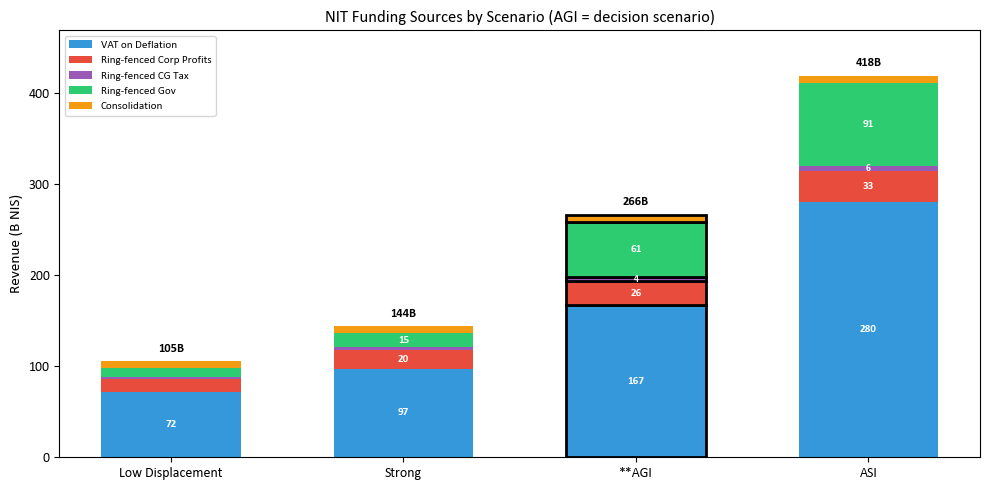

Saved: ..\Paper\Figures\fig3_revenue_waterfall.pdf


In [15]:
# Figure 3: Revenue Waterfall (Paper Figure 3)
fig, ax = plt.subplots(figsize=(10, 5))

scenarios = ['Low Displacement', 'Strong', '**AGI', 'ASI']  # AGI is decision-relevant
x = np.arange(len(scenarios))
width = 0.6

# Revenue components (5 total)
vat = [get('dynamic_vat_low_displacement'), get('dynamic_vat_strong'), get('dynamic_vat_agi'), get('dynamic_vat_asi')]
ring = [get('ringfenced_low_displacement'), get('ringfenced_strong'), get('ringfenced_agi'), get('ringfenced_asi')]
cg = [get('cg_ringfenced_low_displacement'), get('cg_ringfenced_strong'), get('cg_ringfenced_agi'), get('cg_ringfenced_asi')]
gad = [get('ringfenced_gov_low_displacement'), get('ringfenced_gov_strong'), get('ringfenced_gov_agi'), get('ringfenced_gov_asi')]
consol = [get('consolidation_revenue')] * 4

# Calculate max for y-axis scaling
totals = [get('revenue_low_displacement'), get('revenue_strong'), get('revenue_agi'), get('revenue_asi')]
max_total = max(totals)
y_max = max_total * 1.12  # 12% headroom for labels

# Stacked bars - AGI highlighted with edge
bars_vat = ax.bar(x, vat, width, label='VAT on Deflation', color='#3498db')
bars_ring = ax.bar(x, ring, width, bottom=vat, label='Ring-fenced Corp Profits', color='#e74c3c')
bars_cg = ax.bar(x, cg, width, bottom=[v+r for v,r in zip(vat, ring)], label='Ring-fenced CG Tax', color='#9b59b6')
bars_gad = ax.bar(x, gad, width, bottom=[v+r+c for v,r,c in zip(vat, ring, cg)], label='Ring-fenced Gov', color='#2ecc71')
bars_con = ax.bar(x, consol, width, bottom=[v+r+c+g for v,r,c,g in zip(vat, ring, cg, gad)], label='Consolidation', color='#f39c12')

# Highlight AGI bar (index 2) with black edge
for bars in [bars_vat, bars_ring, bars_cg, bars_gad, bars_con]:
    bars[2].set_edgecolor('black')
    bars[2].set_linewidth(2)

# Add value labels - adaptive sizing based on component height
for i, (v, r, cg_val, g, cn, t) in enumerate(zip(vat, ring, cg, gad, consol, totals)):
    # VAT label
    if v > 30:
        ax.text(i, v/2, f'{v:.0f}', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    # Ring-fence label
    if r > 15:
        ax.text(i, v + r/2, f'{r:.0f}', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    # CG label - only if tall enough
    if cg_val > 4:
        ax.text(i, v + r + cg_val/2, f'{cg_val:.0f}', ha='center', va='center', fontsize=7, color='white', fontweight='bold')
    # Gov label
    if g > 15:
        ax.text(i, v + r + cg_val + g/2, f'{g:.0f}', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    # Total label at top
    ax.text(i, t + max_total*0.02, f'{t:.0f}B', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Revenue (B NIS)')
ax.set_title('NIT Funding Sources by Scenario (AGI = decision scenario)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_revenue_waterfall.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig3_revenue_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig3_revenue_waterfall.pdf'}")

## 2.7 Revenue Values (for Layer 3 Floor Calculation)

**Note:** Floor calculations have been moved to Layer 3 (verify_layer3.ipynb) which uses
microsimulation as the primary method. The legacy decile-average method is archived in
verify_layer2_legacy.ipynb.

**Revenue values calculated above:**
- Low Displacement: 70.0B NIS
- Strong: 126.3B NIS  
- AGI: 191.4B NIS

**Layer 3 uses these revenues to calculate revenue-constrained floors via microsimulation.**

See `verify_layer2_legacy.ipynb` for the original decile-average floor calculation.

In [16]:
print("=" * 60)
print("2.7 REVENUE VALUES (for Layer 3 Floor Calculation)")
print("=" * 60)

print(f"\nRevenue values calculated above:")
print(f"  Low Displacement: {get('revenue_low_displacement'):.1f}B NIS")
print(f"  Strong: {get('revenue_strong'):.1f}B NIS")
print(f"  AGI: {get('revenue_agi'):.1f}B NIS")
print(f"  ASI: {get('revenue_asi'):.1f}B NIS")

print(f"\n" + "=" * 60)
print("NOTE: Floor calculations moved to Layer 3 (microsimulation)")
print("=" * 60)
print(f"\nPrimary method: Microsimulation in verify_layer3.ipynb")
print(f"  - Captures within-decile income variation")
print(f"  - Yields ~3% higher floors for same revenue")
print(f"  - More accurate cost estimation")
print(f"\nLegacy method: Decile-average in verify_layer2_legacy.ipynb")
print(f"  - Uses decile mean incomes")
print(f"  - Overestimates costs (underestimates sustainable floors)")
print(f"\nNote: AGI = decision scenario; ASI = stress test")

2.7 REVENUE VALUES (for Layer 3 Floor Calculation)

Revenue values calculated above:
  Low Displacement: 105.1B NIS
  Strong: 143.7B NIS
  AGI: 266.0B NIS
  ASI: 418.4B NIS

NOTE: Floor calculations moved to Layer 3 (microsimulation)

Primary method: Microsimulation in verify_layer3.ipynb
  - Captures within-decile income variation
  - Yields ~3% higher floors for same revenue
  - More accurate cost estimation

Legacy method: Decile-average in verify_layer2_legacy.ipynb
  - Uses decile mean incomes
  - Overestimates costs (underestimates sustainable floors)

Note: AGI = decision scenario; ASI = stress test


## Figure 3: NIT Benefit Schedule

**Moved to Layer 3** (verify_layer3.ipynb) - Generated after microsim floor calculation.

See also: verify_layer2_legacy.ipynb for legacy figure with decile-average floors.

In [17]:
# Figure 3: NIT Benefit Schedule - MOVED TO LAYER 3
print("Figure 3 (NIT Benefit Schedule) is now generated in verify_layer3.ipynb")
print("  - Uses microsimulation floors (primary method)")
print("  - Legacy version available in verify_layer2_legacy.ipynb")

Figure 3 (NIT Benefit Schedule) is now generated in verify_layer3.ipynb
  - Uses microsimulation floors (primary method)
  - Legacy version available in verify_layer2_legacy.ipynb


## Figure 5: Floor vs Revenue Relationship

**Moved to Layer 3** (verify_layer3.ipynb) - Generated after microsim floor calculation.

See also: verify_layer2_legacy.ipynb for legacy figure with decile-average floors.

In [18]:
# Figure 5: Floor vs Revenue - MOVED TO LAYER 3
print("Figure 5 (Floor vs Revenue) is now generated in verify_layer3.ipynb")
print("  - Uses microsimulation floors (primary method)")
print("  - Legacy version available in verify_layer2_legacy.ipynb")

Figure 5 (Floor vs Revenue) is now generated in verify_layer3.ipynb
  - Uses microsimulation floors (primary method)
  - Legacy version available in verify_layer2_legacy.ipynb
